In [ ]:
!pip install scprep umap-learn magic-impute s_gd2 hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 476 kB/s 
     |████████████████████████████████| 88 kB 1.4 MB/s 
     |████████████████████████████████| 416 kB 37.0 MB/s 
     |████████████████████████████████| 5.2 MB 36.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 1.8 MB 48.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cc115d7487e58d796a8d1a26d91d8444bc36a36f81b82b6c1aecb567bcdec1ac
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=4f8dac1f77da1ba

In [ ]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import umap

import time

def run_pca(data,n_components=30,random_state =1):
    today= time.ctime()
  
    
    pca = PCA(n_components=n_components, random_state=random_state)
    pca_data= pca.fit_transform(data)
    print('process start',today)
    return pca_data


def run_umap(pca_data, n_neighbors=15, n_components=2, metric='euclidean', metric_kwds=None,
             output_metric='euclidean', output_metric_kwds=None, n_epochs=None, learning_rate=1.0, 
             init='spectral', min_dist=0.1, spread=1.0, low_memory=True, n_jobs=-1, set_op_mix_ratio=1.0, 
             local_connectivity=1.0, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0,
             a=None, b=None, random_state=None, angular_rp_forest=False, target_n_neighbors=-1,
             target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=42,
             transform_mode='embedding', force_approximation_algorithm=False, verbose=False, 
             unique=False, densmap=False, dens_lambda=2.0, dens_frac=0.3, dens_var_shift=0.1, 
             output_dens=False, disconnection_distance=None):
    
    fit = umap.UMAP(n_neighbors, n_components, metric, metric_kwds,
             output_metric, output_metric_kwds, n_epochs, learning_rate, 
             init, min_dist, spread, low_memory, n_jobs, set_op_mix_ratio, 
             local_connectivity, repulsion_strength, negative_sample_rate, transform_queue_size,
             a, b, random_state, angular_rp_forest, target_n_neighbors,
             target_metric, target_metric_kwds, target_weight, transform_seed,
             transform_mode, force_approximation_algorithm, verbose, 
             unique, densmap, dens_lambda, dens_frac, dens_var_shift, 
             output_dens, disconnection_distance)
    dim_reduction = fit.fit_transform(pca_data)
    
    return dim_reduction


def sc_PHENIX(data, umap_data,t=10,decay=15,metric='euclidean',knn=10):



    print('calculando distancias')
    
    distance_matrix =pdist(umap_data, metric)
    distance_matrix = (squareform(distance_matrix))
    D = distance_matrix
    
    print(distance_matrix.shape)
    print('done distance matrix')
    print('knn')

    print(' knn done')
    print(' afinity matrix')


    n,m =D.shape

    E = np.zeros((m,m))
    
    knn_dst = np.sort(distance_matrix, axis=1)
    

    epsilon = knn_dst[:,knn]
    
    
    pdx_scale = (distance_matrix / epsilon).T 
    
    E = np.exp(-1 * ( pdx_scale ** decay))
    
    print(' afinity matrix done')
    
    A = (E + E.T)
    
    diff_deg = np.diag(np.sum(A,0))
    
    
    diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),A)
    

    new_matrix =  np.linalg.matrix_power(diff_op, t)


    data_new = np.array(np.dot(new_matrix,data))
    
    print('imputation')
    
    Matix_col_genes_row_cell2 = (data +1) - data
    
    Matix_col_genes_row_cell2 = Matix_col_genes_row_cell2 - Matix_col_genes_row_cell2
    
    Matix_impu = Matix_col_genes_row_cell2 + data_new

    
    sc_PHENIX = Matix_impu 
    
    print('done')
    end= time.ctime()
    print('done',end)


    return (sc_PHENIX)


def sc_PHENIX_R(data, umap_data, t=10,decay=15,metric='cosine',knn=10):
    


    print('calculando distancias eucle')
    
    distance_matrix =pdist(umap_data, metric)
    distance_matrix = (squareform(distance_matrix))
    D = distance_matrix
    
    print(distance_matrix.shape)
    print('done distance matrix')
    print('knn')

    print(' knn done')
    print(' afinity matrix')


    n,m =D.shape

    E = np.zeros((m,m))
    
    knn_dst = np.sort(distance_matrix, axis=1)
    

    epsilon = knn_dst[:,knn]
    
    
    pdx_scale = (distance_matrix / epsilon).T 
    
    E = np.exp(-1 * ( pdx_scale ** decay))
    
    print(' afinity matrix done')
    
    A = (E + E.T)
    
    diff_deg = np.diag(np.sum(A,0))
    
    
    diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),A)
    

    new_matrix =  np.linalg.matrix_power(diff_op, t)


    data_new = np.array(np.dot(new_matrix,data))



    rescale_percent =99.99
    M99 = np.percentile(data, rescale_percent, axis=0)
    M100 = data.max(axis=0)
    indices = np.where(M99 == 0)[0]
    M99[indices] = M100[indices]



    M99_new = np.percentile(data_new, rescale_percent, axis=0)
    M100_new = data_new.max(axis=0)
    indices = np.where(M99_new == 0)[0]
    M99_new[indices] = M100_new[indices]


    max_ratio = np.divide(M99, M99_new)
    data_new = np.multiply(data_new, np.tile(max_ratio, (len(data), 1)))



    print('reescalate')

    
    print('imputation')
    
    Matix_col_genes_row_cell2 = (data +1) - data
    
    Matix_col_genes_row_cell2 = Matix_col_genes_row_cell2 - Matix_col_genes_row_cell2
    
    Matix_impu = Matix_col_genes_row_cell2 + data_new

    
    Matix_impu = Matix_impu 
    
    print('done')
    end= time.ctime()
    print('done',end)


    return (Matix_impu)


In [ ]:
import pandas as pd
day_clus = pd.read_csv('kmeans_Class_uMAP_6000.csv')
day_clus

,Unnamed: 0,x
0,D6_1,3
1,D6_2,2
2,D6_3,3
3,D6_4,3
4,D6_5,3
...,...,...
358,D19_226,3
359,D19_227,2
360,D19_228,1
361,D19_229,2


In [ ]:
raw = pd.read_csv('MCTS_b.csv',sep=';',header=[0],index_col=0).T

In [ ]:
raw

,RN7SK,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADAC,...,RP11-254F7.3,TAS2R12P,OR2A20P,HMCN2,RP11-38O14.6,CHSY3,RP3-395C13.1,CTD-2020K17.1,KRT18P46,RNU6ATAC35P
D6_1,0,0,0,0,0,0,0,8,2,0,...,0,0,0,0,0,0,0,0,0,0
D6_2,0,0,0,0,2,0,0,4,10,0,...,0,0,0,0,0,0,0,0,0,0
D6_3,0,0,0,0,0,0,0,5,7,0,...,0,0,0,0,0,0,0,0,0,0
D6_4,2,0,2,0,0,0,0,0,11,0,...,0,0,0,0,0,0,0,0,0,0
D6_5,2,0,0,0,0,0,1,4,9,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D19_226,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D19_227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D19_228,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
D19_229,0,4,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


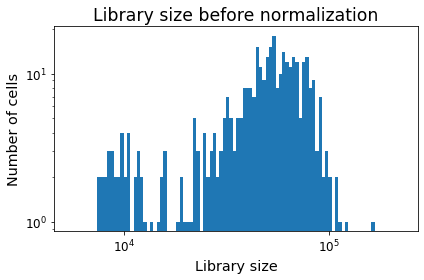

In [ ]:
import scprep
scprep.plot.plot_library_size(raw,title='Library size before normalization')

In [ ]:
#data normalization
data_norm, library_size = scprep.normalize.library_size_normalize(raw, return_library_size=True)

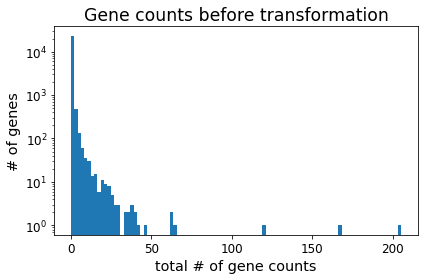

In [ ]:
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In [ ]:
data_sqrt = scprep.transform.sqrt(data_norm)

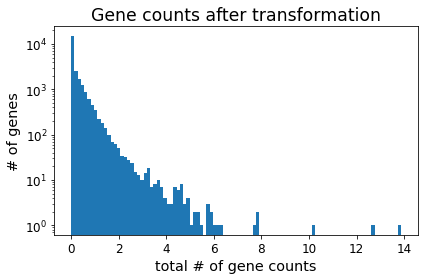

In [ ]:
scprep.plot.histogram(data_sqrt.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

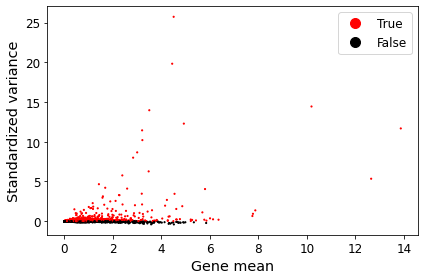

In [ ]:
scprep.plot.plot_gene_variability(data_sqrt, percentile=85)

In [ ]:
data_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=85)

In [ ]:
dim_reduction = pd.read_csv('/content/Umap_coordinates_clusters.csv')
dim_reduction= dim_reduction
dim_reduction

,Unnamed: 0,V1,V2,k1$cluster
0,D19_1,-1.472687,-4.765218,3
1,D19_10,1.083237,3.160249,1
2,D19_100,0.756240,-1.242957,2
3,D19_101,0.495016,-0.165445,2
4,D19_102,-1.322899,-0.786515,2
...,...,...,...,...
358,D6_95,0.145756,1.044993,2
359,D6_96,-1.465150,2.300778,1
360,D6_97,0.062696,-6.033323,3
361,D6_98,1.471117,0.528763,2


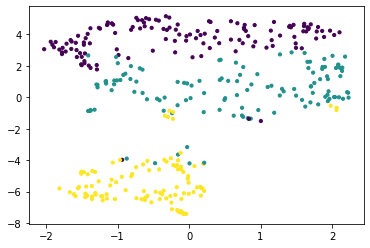

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(dim_reduction['V1'], dim_reduction['V2'], c=dim_reduction['k1$cluster'], s=10)
plt.show()

In [ ]:
#dim_reduction_umap= dim_reduction[['V1','V2']]
#dim_reduction_umap.shape
dim_reduction

,Unnamed: 0,V1,V2,k1$cluster
0,D19_1,-1.472687,-4.765218,3
1,D19_10,1.083237,3.160249,1
2,D19_100,0.756240,-1.242957,2
3,D19_101,0.495016,-0.165445,2
4,D19_102,-1.322899,-0.786515,2
...,...,...,...,...
358,D6_95,0.145756,1.044993,2
359,D6_96,-1.465150,2.300778,1
360,D6_97,0.062696,-6.033323,3
361,D6_98,1.471117,0.528763,2


In [ ]:
data_sqrt

,RN7SK,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADAC,...,RP11-254F7.3,TAS2R12P,OR2A20P,HMCN2,RP11-38O14.6,CHSY3,RP3-395C13.1,CTD-2020K17.1,KRT18P46,RNU6ATAC35P
D6_1,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.697199,0.348599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_2,0.000000,0.00000,0.000000,0.0,0.405908,0.0,0.000000,0.574040,0.907637,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_3,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.672469,0.795676,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_4,0.426458,0.00000,0.426458,0.0,0.000000,0.0,0.000000,0.000000,1.000132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_5,0.441683,0.00000,0.000000,0.0,0.000000,0.0,0.312317,0.624634,0.936951,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D19_226,1.002913,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_227,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_228,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.583417,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_229,0.000000,2.29961,0.000000,0.0,0.000000,0.0,0.000000,1.991521,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

data_all = data_sqrt.reset_index()
data_all.rename(columns = {'index':'Unnamed: 0'}, inplace = True)

result_all = pd.merge(data_all,dim_reduction,on='Unnamed: 0')
result_all

,Unnamed: 0,RN7SK,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,...,HMCN2,RP11-38O14.6,CHSY3,RP3-395C13.1,CTD-2020K17.1,KRT18P46,RNU6ATAC35P,V1,V2,k1$cluster
0,D6_1,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.697199,0.348599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.068019,-4.154163,3
1,D6_2,0.000000,0.00000,0.000000,0.0,0.405908,0.0,0.000000,0.574040,0.907637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.430111,1.102717,2
2,D6_3,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.672469,0.795676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.037960,-6.476896,3
3,D6_4,0.426458,0.00000,0.426458,0.0,0.000000,0.0,0.000000,0.000000,1.000132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.612801,-6.390413,3
4,D6_5,0.441683,0.00000,0.000000,0.0,0.000000,0.0,0.312317,0.624634,0.936951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.357999,-6.473364,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,D19_226,1.002913,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.347560,-3.978606,3
359,D19_227,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624496,-1.168456,2
360,D19_228,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.583417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.867982,3.517514,1
361,D19_229,0.000000,2.29961,0.000000,0.0,0.000000,0.0,0.000000,1.991521,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.386026,-0.861408,2


In [ ]:
result_all = result_all.iloc[:,:23923].set_index('Unnamed: 0')

In [ ]:
result_all

,RN7SK,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADAC,...,RP11-254F7.3,TAS2R12P,OR2A20P,HMCN2,RP11-38O14.6,CHSY3,RP3-395C13.1,CTD-2020K17.1,KRT18P46,RNU6ATAC35P
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
D6_1,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.697199,0.348599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_2,0.000000,0.00000,0.000000,0.0,0.405908,0.0,0.000000,0.574040,0.907637,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_3,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.672469,0.795676,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_4,0.426458,0.00000,0.426458,0.0,0.000000,0.0,0.000000,0.000000,1.000132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_5,0.441683,0.00000,0.000000,0.0,0.000000,0.0,0.312317,0.624634,0.936951,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D19_226,1.002913,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_227,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_228,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.583417,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
result_all.to_csv('MCTS_B_MENOSUNAMUESTRA.CSV')

In [ ]:
data_hvg=data_hvg.reset_index()
data_hvg

,index,A1BG,AAMDC,AARD,AARSD1,AASDH,AASDHPPT,ABAT,ABCA12,ABCA5,...,CTB-58E17.3,CTD-2537I9.13,VWDE,ADGRB1,RP4-569M23.4,IL1B,GBP4,AC106873.4,AQP4-AS1,RP11-535A19.1
0,D6_1,0.00000,0.492994,0.697199,0.348599,0.246497,0.603792,2.351431,0.888757,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
1,D6_2,0.00000,0.000000,0.574040,0.000000,0.000000,0.907637,1.315291,1.111624,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2,D6_3,0.00000,0.000000,0.795676,0.000000,0.425307,0.601475,1.925658,1.239971,0.300737,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
3,D6_4,0.00000,0.674289,1.044604,0.000000,0.000000,0.674289,1.243327,0.738646,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
4,D6_5,0.00000,0.000000,1.464897,0.000000,0.000000,0.000000,1.530035,0.765017,0.765017,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,D19_226,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.005825,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
360,D19_227,0.00000,0.000000,0.000000,0.000000,0.000000,1.786379,2.526321,1.031366,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
361,D19_228,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119645,0.000000,0.000000,...,2.239289,2.239289,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.239289
362,D19_229,2.29961,0.000000,0.000000,0.000000,2.299610,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,1.62607,0.0,0.0,0.0,0.0,0.000000


In [ ]:
data_hvg.rename(columns = {'index':'Unnamed: 0'}, inplace = True)
data_hvg

,Unnamed: 0,A1BG,AAMDC,AARD,AARSD1,AASDH,AASDHPPT,ABAT,ABCA12,ABCA5,...,CTB-58E17.3,CTD-2537I9.13,VWDE,ADGRB1,RP4-569M23.4,IL1B,GBP4,AC106873.4,AQP4-AS1,RP11-535A19.1
0,D6_1,0.00000,0.492994,0.697199,0.348599,0.246497,0.603792,2.351431,0.888757,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
1,D6_2,0.00000,0.000000,0.574040,0.000000,0.000000,0.907637,1.315291,1.111624,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2,D6_3,0.00000,0.000000,0.795676,0.000000,0.425307,0.601475,1.925658,1.239971,0.300737,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
3,D6_4,0.00000,0.674289,1.044604,0.000000,0.000000,0.674289,1.243327,0.738646,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
4,D6_5,0.00000,0.000000,1.464897,0.000000,0.000000,0.000000,1.530035,0.765017,0.765017,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,D19_226,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.005825,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
360,D19_227,0.00000,0.000000,0.000000,0.000000,0.000000,1.786379,2.526321,1.031366,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
361,D19_228,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119645,0.000000,0.000000,...,2.239289,2.239289,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.239289
362,D19_229,2.29961,0.000000,0.000000,0.000000,2.299610,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,1.62607,0.0,0.0,0.0,0.0,0.000000


In [ ]:
result = pd.merge(data_hvg,dim_reduction,on='Unnamed: 0')
result

,Unnamed: 0,A1BG,AAMDC,AARD,AARSD1,AASDH,AASDHPPT,ABAT,ABCA12,ABCA5,...,ADGRB1,RP4-569M23.4,IL1B,GBP4,AC106873.4,AQP4-AS1,RP11-535A19.1,V1,V2,k1$cluster
0,D6_1,0.00000,0.492994,0.697199,0.348599,0.246497,0.603792,2.351431,0.888757,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,-1.068019,-4.154163,3
1,D6_2,0.00000,0.000000,0.574040,0.000000,0.000000,0.907637,1.315291,1.111624,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.430111,1.102717,2
2,D6_3,0.00000,0.000000,0.795676,0.000000,0.425307,0.601475,1.925658,1.239971,0.300737,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,-1.037960,-6.476896,3
3,D6_4,0.00000,0.674289,1.044604,0.000000,0.000000,0.674289,1.243327,0.738646,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,-0.612801,-6.390413,3
4,D6_5,0.00000,0.000000,1.464897,0.000000,0.000000,0.000000,1.530035,0.765017,0.765017,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,-1.357999,-6.473364,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,D19_226,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.005825,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,-0.347560,-3.978606,3
359,D19_227,0.00000,0.000000,0.000000,0.000000,0.000000,1.786379,2.526321,1.031366,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.624496,-1.168456,2
360,D19_228,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119645,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,2.239289,-1.867982,3.517514,1
361,D19_229,2.29961,0.000000,0.000000,0.000000,2.299610,0.000000,0.000000,0.000000,0.000000,...,0.0,1.62607,0.0,0.0,0.0,0.0,0.000000,-1.386026,-0.861408,2


In [ ]:
result_all

,RN7SK,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADAC,...,RP11-254F7.3,TAS2R12P,OR2A20P,HMCN2,RP11-38O14.6,CHSY3,RP3-395C13.1,CTD-2020K17.1,KRT18P46,RNU6ATAC35P
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
D6_1,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.697199,0.348599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_2,0.000000,0.00000,0.000000,0.0,0.405908,0.0,0.000000,0.574040,0.907637,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_3,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.672469,0.795676,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_4,0.426458,0.00000,0.426458,0.0,0.000000,0.0,0.000000,0.000000,1.000132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D6_5,0.441683,0.00000,0.000000,0.0,0.000000,0.0,0.312317,0.624634,0.936951,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D19_226,1.002913,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_227,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D19_228,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.583417,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
result_data = result.iloc[:,:-3]
result_data

,Unnamed: 0,A1BG,AAMDC,AARD,AARSD1,AASDH,AASDHPPT,ABAT,ABCA12,ABCA5,...,CTB-58E17.3,CTD-2537I9.13,VWDE,ADGRB1,RP4-569M23.4,IL1B,GBP4,AC106873.4,AQP4-AS1,RP11-535A19.1
0,D6_1,0.00000,0.492994,0.697199,0.348599,0.246497,0.603792,2.351431,0.888757,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
1,D6_2,0.00000,0.000000,0.574040,0.000000,0.000000,0.907637,1.315291,1.111624,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2,D6_3,0.00000,0.000000,0.795676,0.000000,0.425307,0.601475,1.925658,1.239971,0.300737,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
3,D6_4,0.00000,0.674289,1.044604,0.000000,0.000000,0.674289,1.243327,0.738646,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
4,D6_5,0.00000,0.000000,1.464897,0.000000,0.000000,0.000000,1.530035,0.765017,0.765017,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,D19_226,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.005825,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
359,D19_227,0.00000,0.000000,0.000000,0.000000,0.000000,1.786379,2.526321,1.031366,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
360,D19_228,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119645,0.000000,0.000000,...,2.239289,2.239289,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.239289
361,D19_229,2.29961,0.000000,0.000000,0.000000,2.299610,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,1.62607,0.0,0.0,0.0,0.0,0.000000


In [ ]:
result_data= result_data.set_index('Unnamed: 0')
result_data

,A1BG,AAMDC,AARD,AARSD1,AASDH,AASDHPPT,ABAT,ABCA12,ABCA5,ABCC1,...,CTB-58E17.3,CTD-2537I9.13,VWDE,ADGRB1,RP4-569M23.4,IL1B,GBP4,AC106873.4,AQP4-AS1,RP11-535A19.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
D6_1,0.00000,0.492994,0.697199,0.348599,0.246497,0.603792,2.351431,0.888757,0.000000,0.348599,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D6_2,0.00000,0.000000,0.574040,0.000000,0.000000,0.907637,1.315291,1.111624,0.000000,0.703052,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D6_3,0.00000,0.000000,0.795676,0.000000,0.425307,0.601475,1.925658,1.239971,0.300737,0.300737,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D6_4,0.00000,0.674289,1.044604,0.000000,0.000000,0.674289,1.243327,0.738646,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D6_5,0.00000,0.000000,1.464897,0.000000,0.000000,0.000000,1.530035,0.765017,0.765017,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D19_226,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.005825,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D19_227,0.00000,0.000000,0.000000,0.000000,0.000000,1.786379,2.526321,1.031366,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
D19_228,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119645,0.000000,0.000000,1.119645,...,2.239289,2.239289,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.239289


In [ ]:
umap = result.iloc[:,3590:3592]
umap

,V1,V2
0,-1.068019,-4.154163
1,0.430111,1.102717
2,-1.037960,-6.476896
3,-0.612801,-6.390413
4,-1.357999,-6.473364
...,...,...
358,-0.347560,-3.978606
359,0.624496,-1.168456
360,-1.867982,3.517514
361,-1.386026,-0.861408


In [ ]:
#cluster= 
cluster= result.iloc[:,3592:]
cluster

,k1$cluster
0,3
1,2
2,3
3,3
4,3
...,...
358,3
359,2
360,1
361,2


In [ ]:
day_1 = day_clus['Unnamed: 0'].str.split('_', 1, expand=True)
day = day_1[0]

In [ ]:
day

0       D6
1       D6
2       D6
3       D6
4       D6
      ... 
358    D19
359    D19
360    D19
361    D19
362    D19
Name: 0, Length: 363, dtype: object

In [ ]:
pca = run_pca(result_data, n_components=30,random_state=1)

process start Wed May 25 21:43:00 2022


In [ ]:
import umap
fit = umap.UMAP(n_components=30,metric='euclidean',n_epochs=1000,min_dist=0.5,verbose=1,random_state=1)
dim_reduction = fit.fit_transform(pca)
#raw  data_hvg pca

UMAP(min_dist=0.5, n_components=30, n_epochs=1000, random_state=1, verbose=1)
Wed May 25 21:43:02 2022 Construct fuzzy simplicial set


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Wed May 25 21:43:02 2022 Finding Nearest Neighbors
Wed May 25 21:43:05 2022 Finished Nearest Neighbor Search
Wed May 25 21:43:09 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Wed May 25 21:43:17 2022 Finished embedding


In [ ]:
#result_all
#result_data

In [ ]:
X_phenix = sc_PHENIX(result_all, dim_reduction,t=5,decay=5,metric='euclidean',knn=20)

calculando distancias
(363, 363)
done distance matrix
knn
 knn done
 afinity matrix
 afinity matrix done
imputation
done
done Wed May 25 21:43:18 2022


Text(0, 0.5, 'VIM')

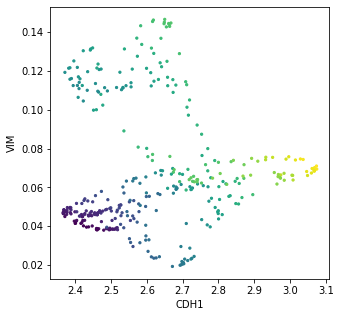

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X_phenix['CDH1'], X_phenix['VIM'], c=X_phenix['BCL2'], s=5)
plt.xlabel('CDH1')
plt.ylabel('VIM')
#plt.title('2D  500 PCA_DIFF_MSD plot', fontsize=24);

Text(0, 0.5, 'VIM')

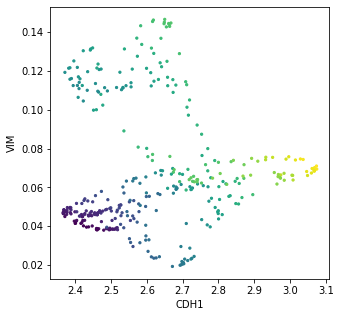

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X_phenix['CDH1'], X_phenix['VIM'], c=X_phenix['BCL2'], s=5)
plt.xlabel('CDH1')
plt.ylabel('VIM')
#plt.title('2D  500 PCA_DIFF_MSD plot', fontsize=24);

In [ ]:
import magic
magic_operator = magic.MAGIC(t=5,decay=5,knn_dist='euclidean',knn=20,n_pca=100)
X_magic = magic_operator.fit_transform(result_all)


Calculating MAGIC...
  Running MAGIC on 363 cells and 23922 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/usr/local/lib/python3.7/dist-packages/magic/magic.py:426: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  "Input matrix contains unexpressed genes. "


    Calculated PCA in 2.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 2.73 seconds.
  Running MAGIC with `solver='exact'` on 23922-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.25 seconds.
Calculated MAGIC in 3.15 seconds.


In [ ]:
X_magic.to_csv('X_magic_impu.csv')

Text(0, 0.5, 'VIM')

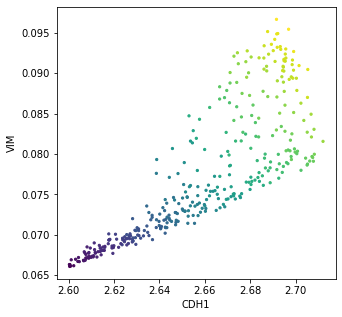

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X_magic['CDH1'], X_magic['VIM'], c=X_magic['BCL2'], s=5)
plt.xlabel('CDH1')
plt.ylabel('VIM')

In [ ]:
pca = run_pca(X_phenix, n_components=3,random_state=1)